# Azure ML Using Python SDK

# Objective:
These are the objectives of this file:
1. Execute a case-study on ML using the Azure Machine Learning Studio.
2. Log the model metrics in Azure ML Studio.
3. Save the created models in pkl format in Azure ML Studio.

We will develop a decision tree model and fine-tune it; using the Azure Python SDK for Machine Learning. We will store the metrics of this model in the associated workspace of Azure ML Studio. We will also save the model in pkl format, which can be used later for deployment. The scope of this case study is limited to logging the metrics and saving the file.

Model deployment is out of scope for the current case study and will be taught in a separate session.

# Prerequisites:
Install the required libraries to enable access to Azure ML.

In [ ]:
# Install libraries required to access the Azure ML services
!pip install azure-ai-ml
!pip install azure-identity
!pip install azureml-core

!pip install azureml-opendatasets

!pip install mlflow

## Importing necessary libraries

In [ ]:
# to connect to the Azure ML resource
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

# to read the local environment variables and secret keys
import os, dotenv
from dotenv import load_dotenv, find_dotenv

# to track the model using Azure MLStudio
import mlflow
import mlflow.sklearn

import joblib

# import 'Pandas'
import pandas as pd

# import 'Numpy'
import numpy as np

# import subpackage of Matplotlib
import matplotlib.pyplot as plt

# import 'Seaborn'
# import seaborn as sns

# to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

# display all columns of the dataframe
pd.options.display.max_columns = None

# display all rows of the dataframe
pd.options.display.max_rows = None

# to display the float values upto 6 decimal places
pd.options.display.float_format = '{:.6f}'.format

# import train-test split
from sklearn.model_selection import train_test_split

# import StandardScaler to perform scaling
from sklearn.preprocessing import StandardScaler

# import various functions from sklearn
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV

# import the functions for visualizing the decision tree
import pydotplus
from IPython.display import Image

# Case Study

## Problem Statement

This dataset is created for the prediction of Graduate admissions from an Indian perspective. The dataset contains various features that are important during the application for the Master's Program. The predicted output obtained from the classification algorithm gives a fair idea about the chances of a student for admission.

## Reading the dataset and EDA

## About the dataset (Graduate admissions prediction data)

**Serial No.:** Serial number of student

**GRE Scores:** GRE score (out of 340)

**TOEFL Scores:** TOEFL score (out of 120)

**University Rating:** University rating (out of 5)

**SOP:** Strength of Statement of Purpose (out of 5)

**LOR:** Strength of Letter of Recommendation (out of 5)

**CGPA:** Undergraduate CGPA (out of 10)

**Chance of Admit:** Chance of admission (target/dependent variable)

In [ ]:
# load the csv file
# store the data in 'df_admissions'
df_admissions = pd.read_csv('Admission_Predict.csv')

# display first five observations using head()
df_admissions.head()

Serial No.  GRE Score  TOEFL Score  University Rating      SOP      LOR  \
0           1        337          118                  4 4.500000 4.500000   
1           2        324          107                  4 4.000000 4.500000   
2           3        316          104                  3 3.000000 3.500000   
3           4        322          110                  3 3.500000 2.500000   
4           5        314          103                  2 2.000000 3.000000   

      CGPA  Chance of Admit  
0 9.650000                1  
1 8.870000                1  
2 8.000000                0  
3 8.670000                1  
4 8.210000                0

In [ ]:
# use 'shape' to check the dimension of data
df_admissions.shape

(400, 8)

In [ ]:
# use 'dtypes' to check the data type of a variable
df_admissions.dtypes

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Chance of Admit        int64
dtype: object

In [ ]:
# drop the column 'Serial No.' using drop()
# 'axis = 1' drops the specified column
df_admissions = df_admissions.drop('Serial No.', axis = 1)

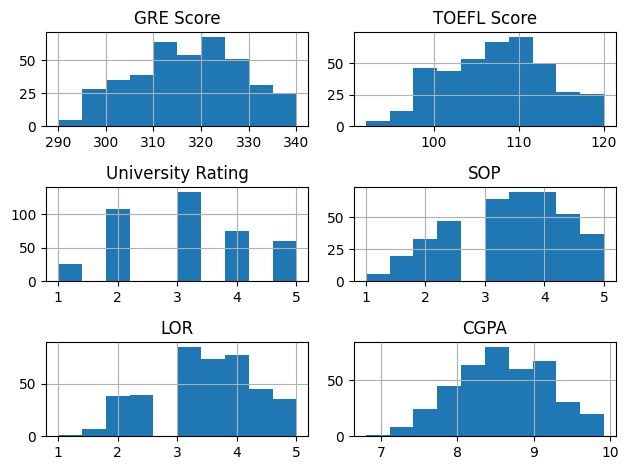

Skewness:


GRE Score           -0.062893
TOEFL Score          0.057216
University Rating    0.171260
SOP                 -0.275761
LOR                 -0.106991
CGPA                -0.065991
dtype: float64

In [ ]:
# for the independent numeric variables, we plot the histogram to check the distribution of the variables
# Note: the hist() function considers the numeric variables only, by default
# we drop the target variable using drop()
# 'axis=1' drops the specified column
df_admissions.drop('Chance of Admit', axis = 1).hist()

# adjust the subplots
plt.tight_layout()

# display the plot
plt.show()

# print the skewness for each numeric independent variable
print('Skewness:')
# we drop the target variable using drop()
# 'axis=1' drops the specified column
# skew() returns the coefficient of skewness for each variable
df_admissions.drop('Chance of Admit', axis = 1).skew()

In [ ]:
# sort the variables on the basis of total null values in the variable
# 'isnull().sum()' returns the number of missing values in each variable
# 'ascending = False' sorts values in the descending order
# the variable with highest number of missing values will appear first
Total = df_admissions.isnull().sum().sort_values(ascending=False)

# calculate percentage of missing values
# 'ascending = False' sorts values in the descending order
# the variable with highest percentage of missing values will appear first
Percent = (df_admissions.isnull().sum()*100/df_admissions.isnull().count()).sort_values(ascending=False)

# concat the 'Total' and 'Percent' columns using 'concat' function
# pass a list of column names in parameter 'keys'
# 'axis = 1' concats along the columns
missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])
missing_data

Total  Percentage of Missing Values
GRE Score              0                      0.000000
TOEFL Score            0                      0.000000
University Rating      0                      0.000000
SOP                    0                      0.000000
LOR                    0                      0.000000
CGPA                   0                      0.000000
Chance of Admit        0                      0.000000

In [ ]:
# store the target variable 'Chance of Admit' in a dataframe 'df_target'
df_target = df_admissions['Chance of Admit']

# store all the independent variables in a dataframe 'X'
# drop the column 'Chance of Admit' using drop()
# 'axis = 1' drops the specified column
X = df_admissions.drop('Chance of Admit', axis = 1)

In [ ]:
# split data into train subset and test subset
# set 'random_state' to generate the same dataset each time you run the code
# 'test_size' returns the proportion of data to be included in the test set
X_train, X_test, y_train, y_test = train_test_split(X, df_target, random_state = 10, test_size = 0.2)

# check the dimensions of the train & test subset using 'shape'
# print dimension of train set
print('X_train', X_train.shape)
print('y_train', y_train.shape)

# print dimension of test set
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (320, 6)
y_train (320,)
X_test (80, 6)
y_test (80,)


# Setting up the Model Runs

## Configure your Azure ML workspace

https://github.com/shambhaviKPrasad/MachineLearningNotebooks/blob/7a3ab1e44cb6d07325f1df8719dd8f76e59dbb4d/configuration.ipynb

The workspace is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning.

Step 1. Create an ML Resource in your resource group

In [ ]:
Image('1.png')

In [ ]:
Image('2.png')

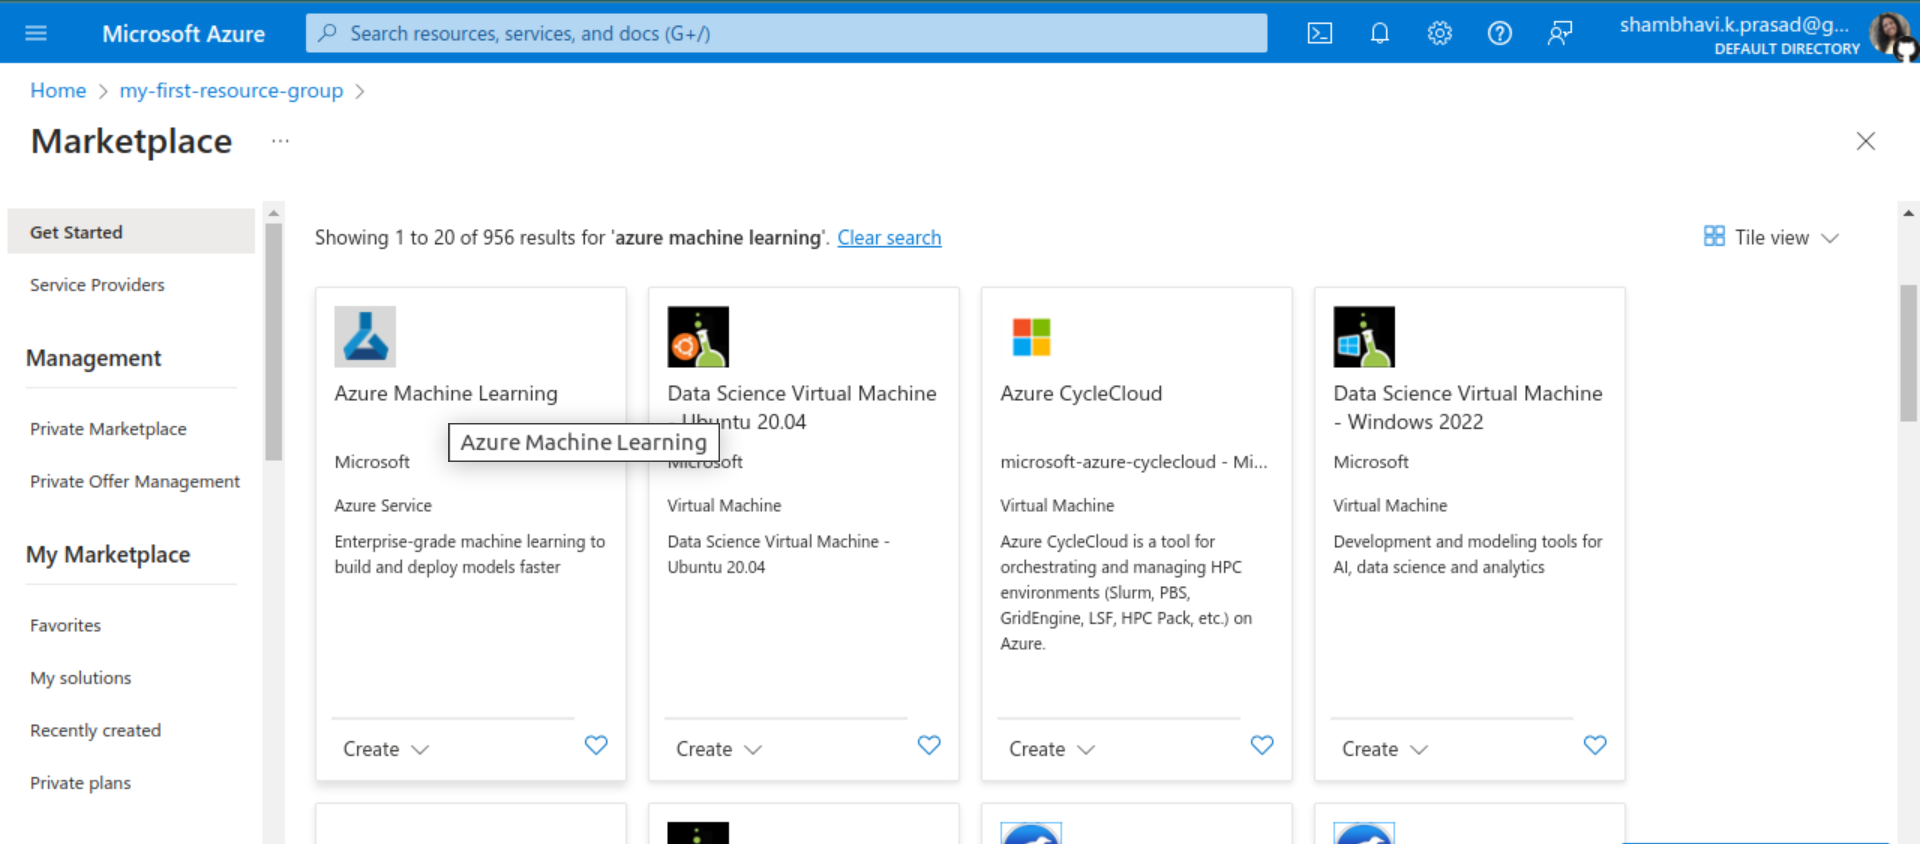

In [ ]:
Image('3.png')

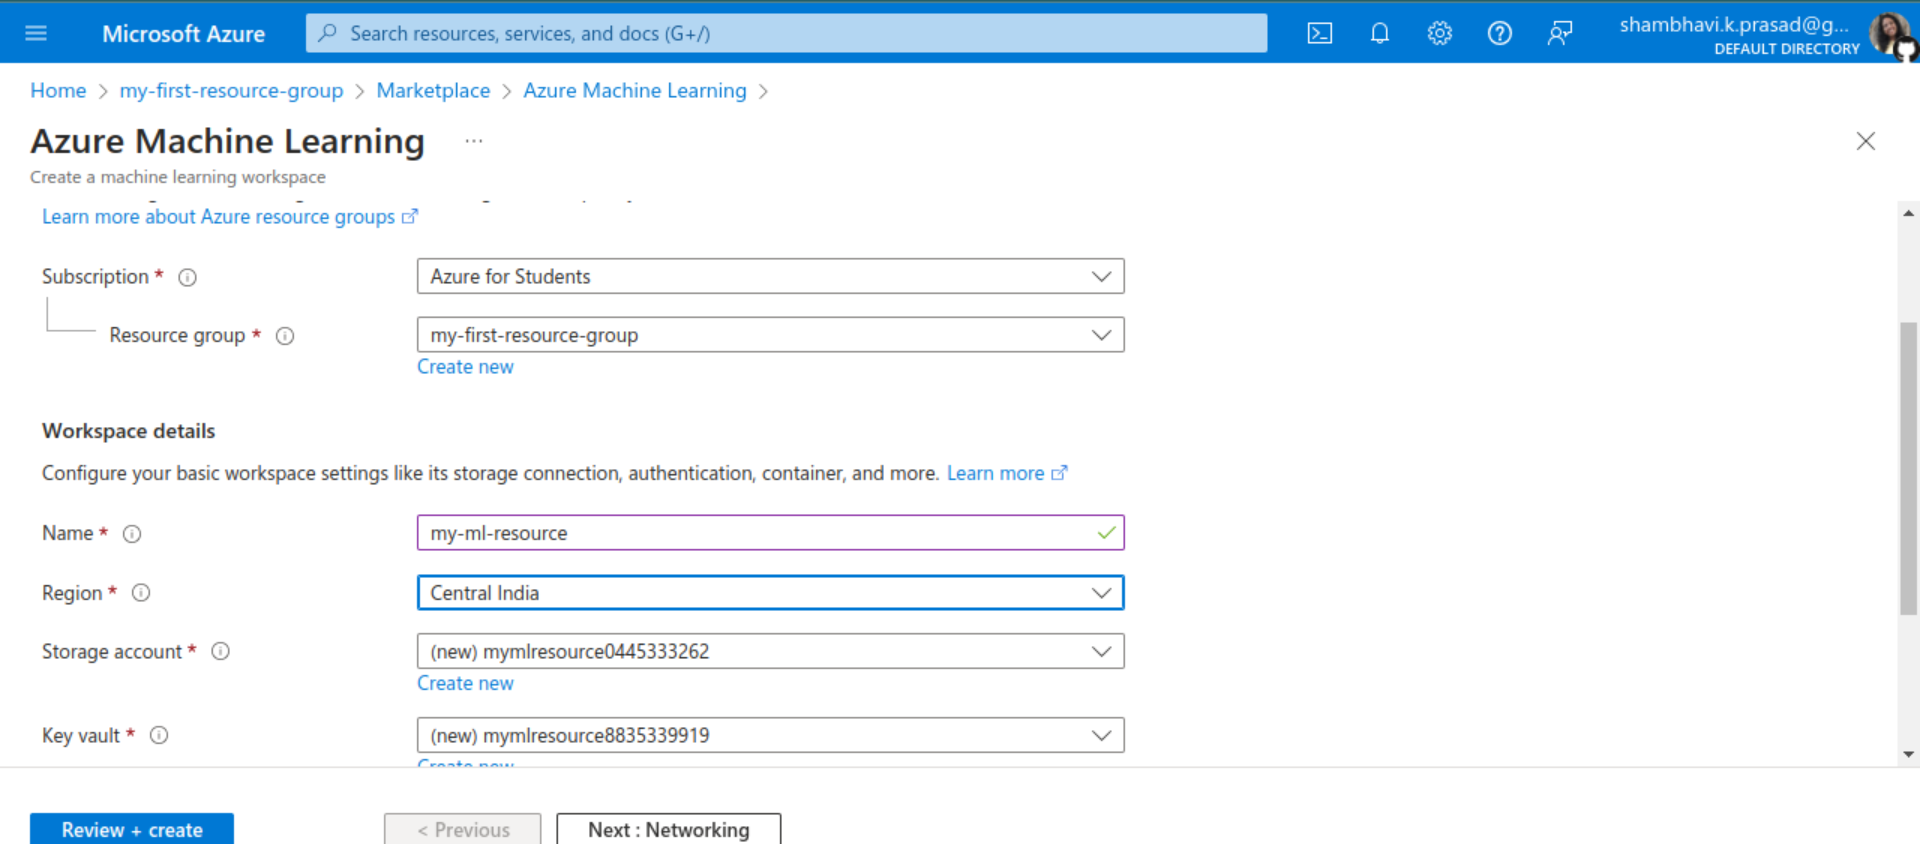

In [ ]:
Image('4.png')

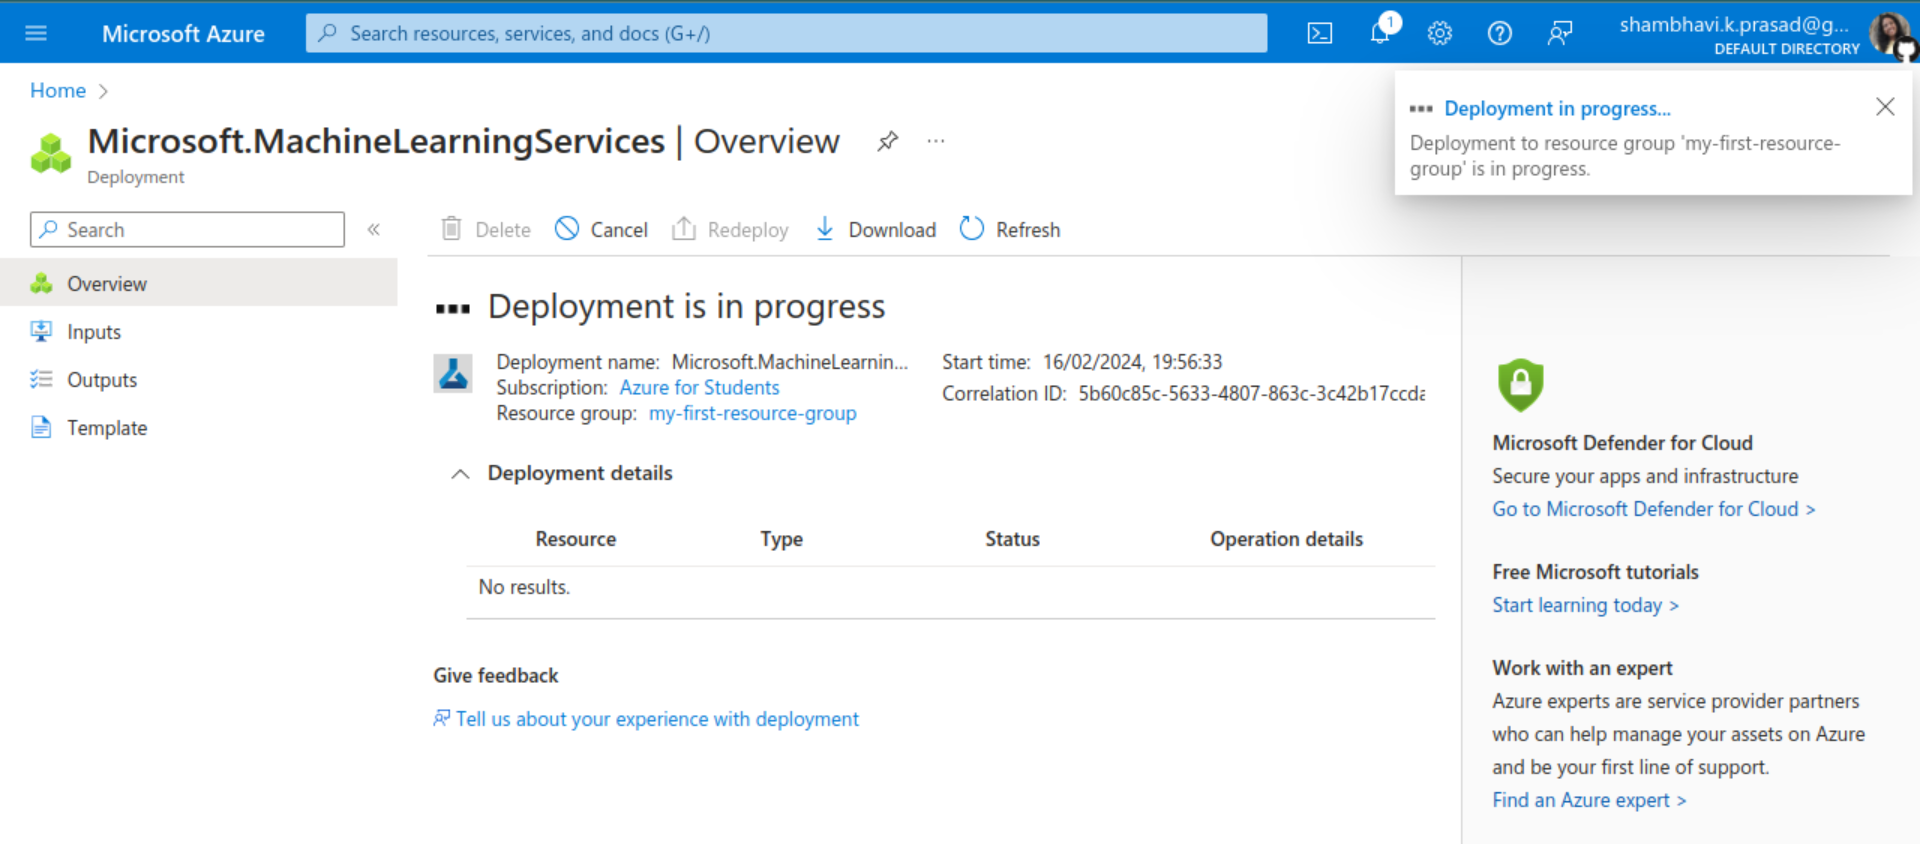

In [ ]:
Image('5.png')

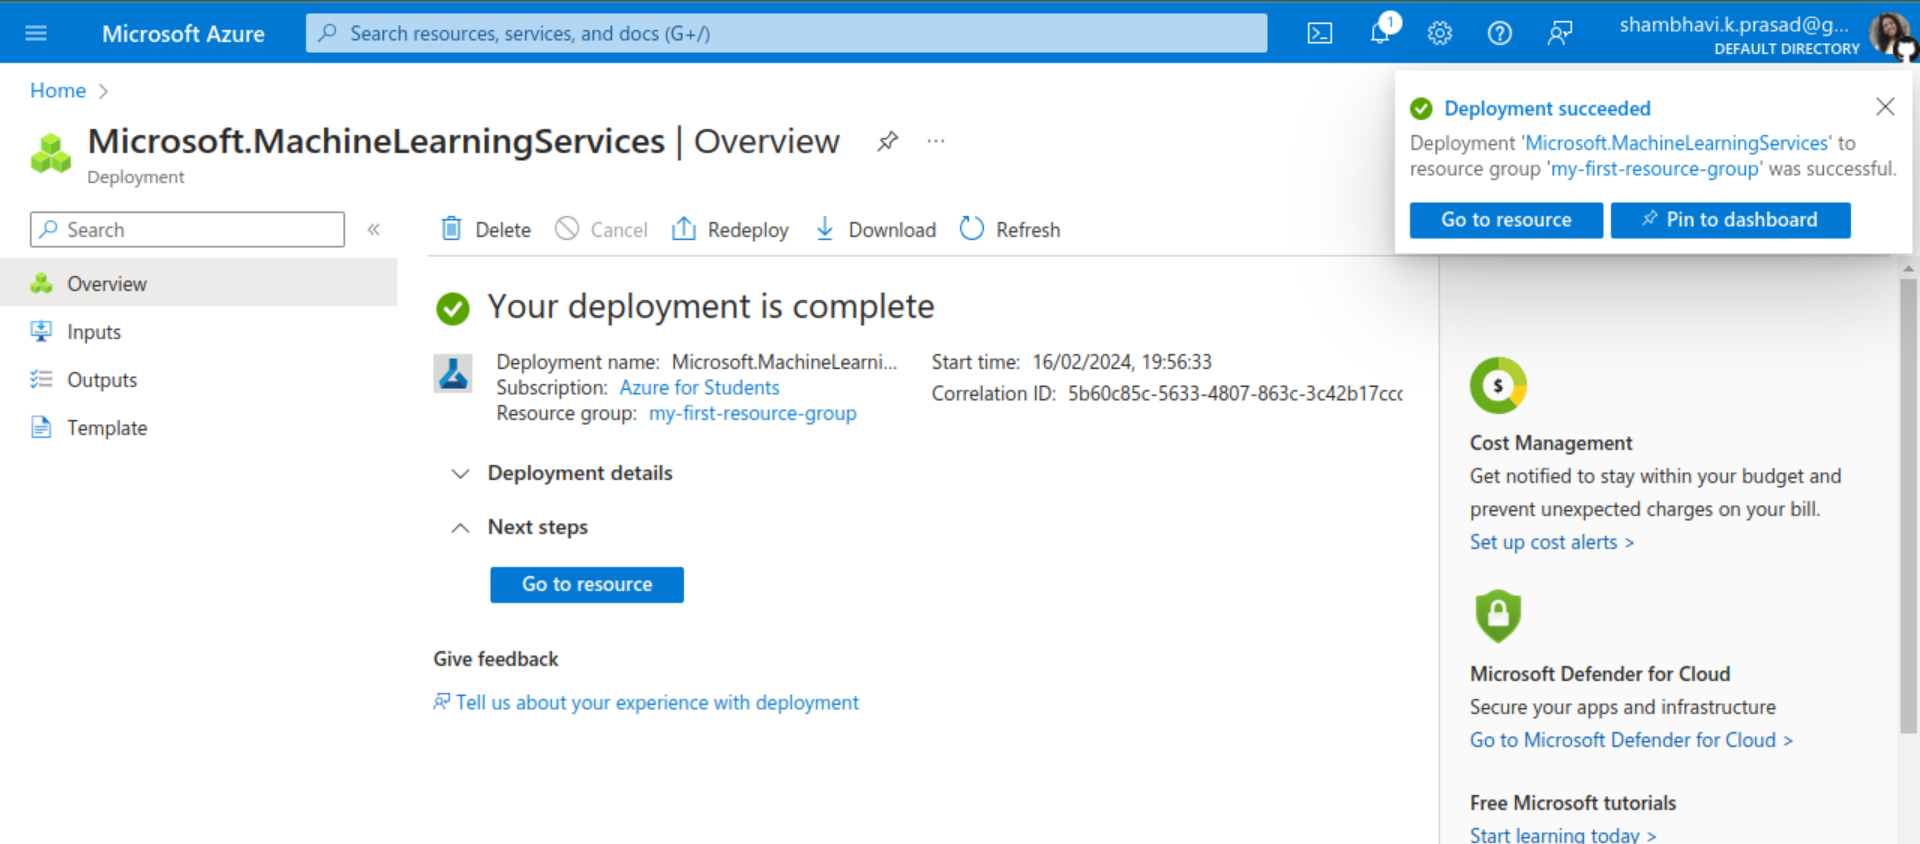

In [ ]:
Image('6.png')

## Access your workspace

https://learn.microsoft.com/en-us/azure/machine-learning/how-to-manage-workspace?view=azureml-api-2&tabs=python#connect-to-a-workspace

### Download the config.json file for the resource from the Portal.

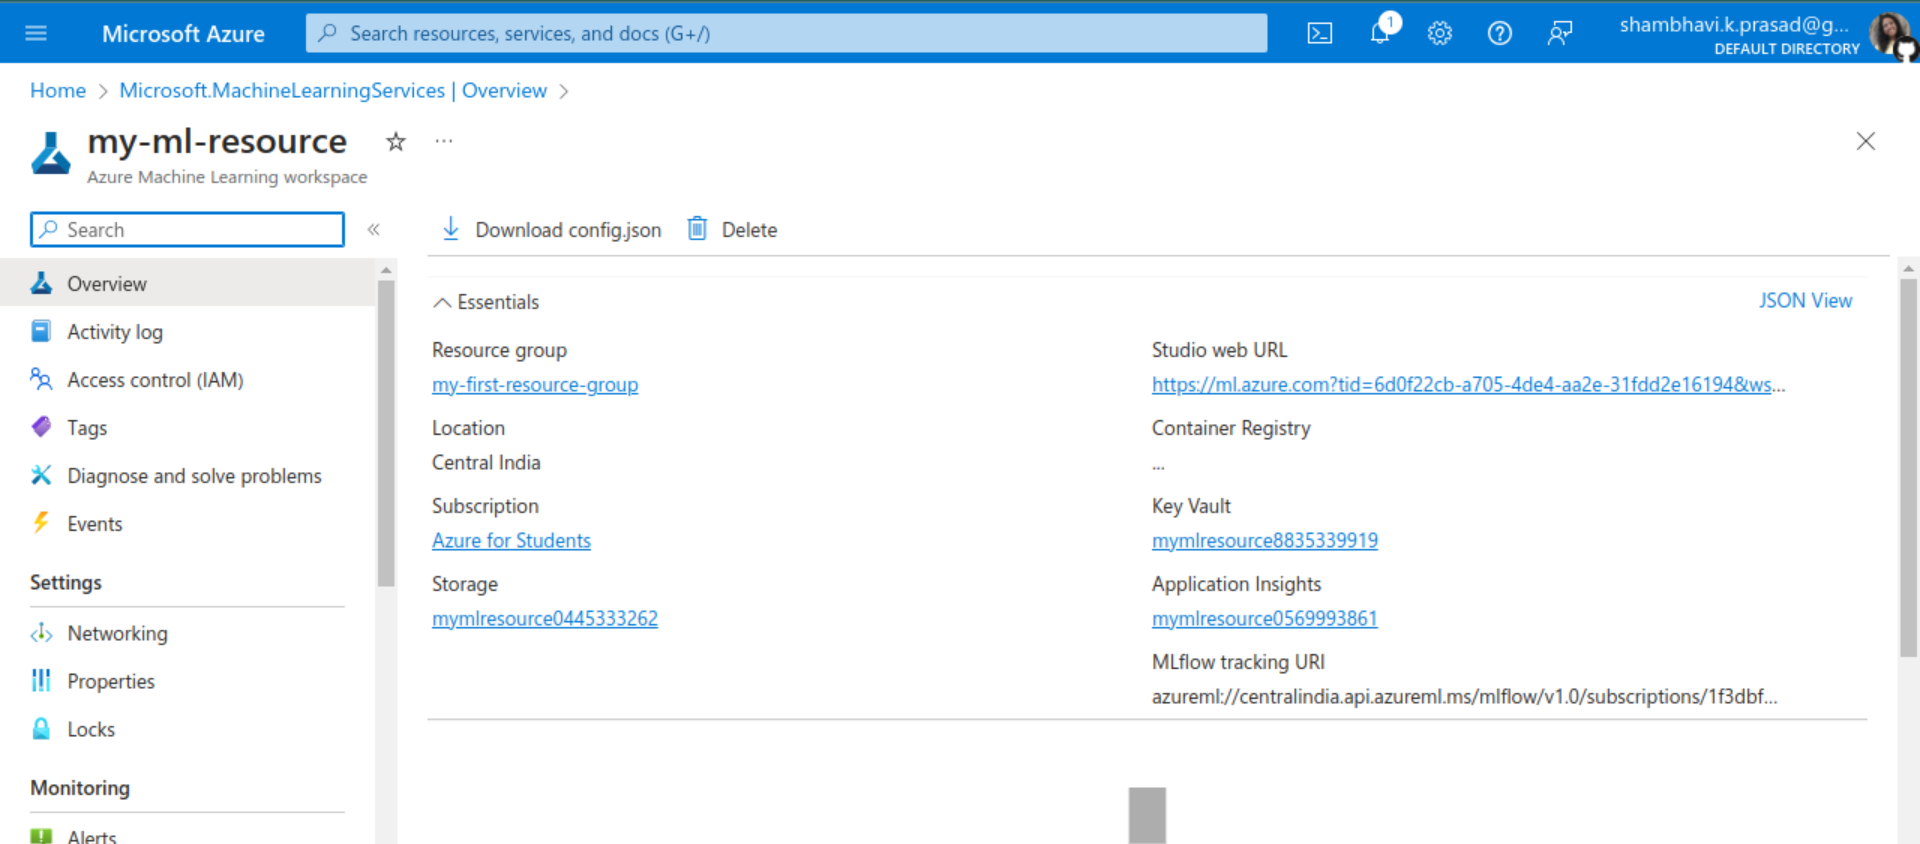

In [ ]:
Image('7.png')

In [ ]:
# Read the config.json file to connect to your workspace from local notebook
from azureml.core import Workspace
ws = Workspace.from_config()

## Copy your Tenant ID to connect to Microsoft CLI.

Search for **Microsoft Entra** to locate your tenant ID.

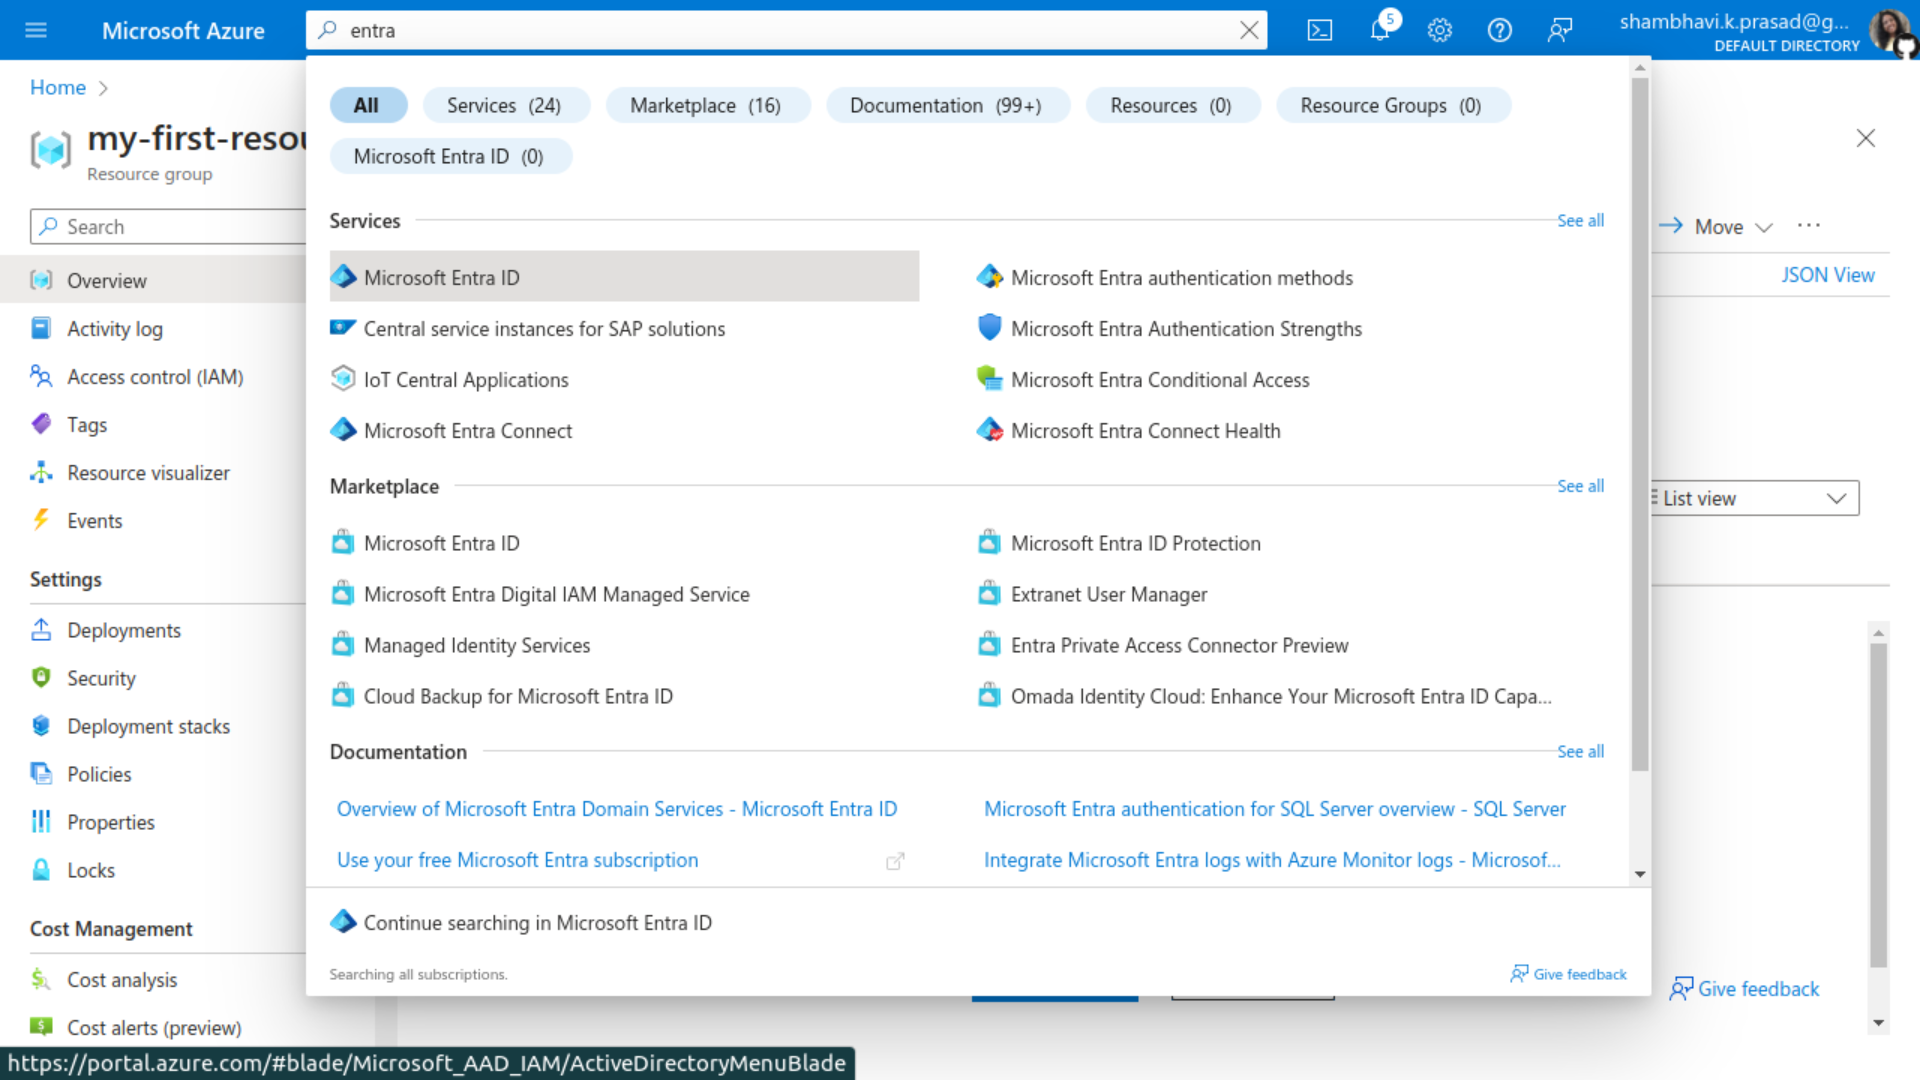

In [ ]:
Image('11.png')

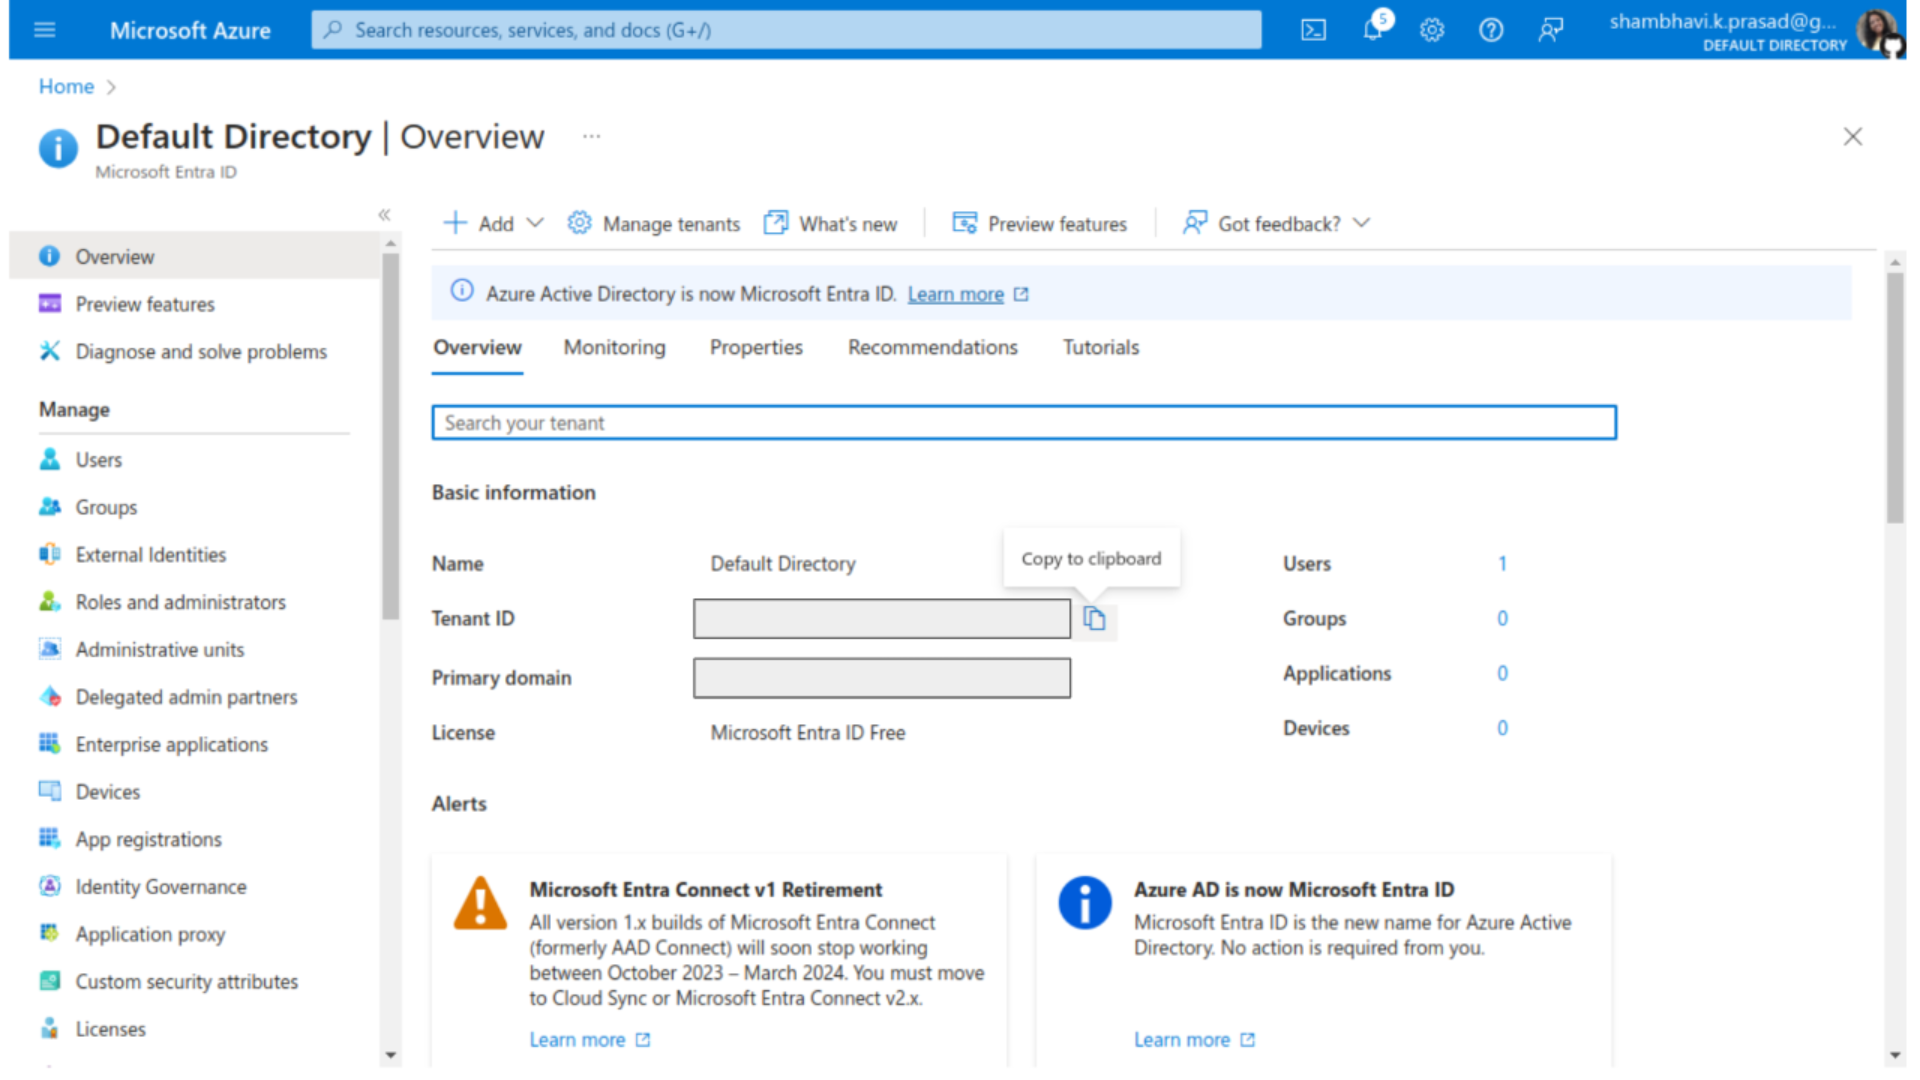

In [ ]:
Image('12.png')

In [ ]:
# Authenticate your tenant to connect to Microsoft CLI
from azureml.core.authentication import InteractiveLoginAuthentication
interactive_auth = InteractiveLoginAuthentication(tenant_id="<your-tenant_id>")

## Create new experiment
Now create an experiment in your workspace. An experiment is another foundational cloud resource that represents a collection of trials (individual model runs).

In [ ]:
from azureml.core import Experiment
experiment = Experiment(workspace = ws, name="graduate-admission-prediction-using-python-sdk")

In [ ]:
# set name for logging
mlflow.set_experiment("graduate-admission-prediction-using-python-sdk")
# enable autologging with MLflow
mlflow.sklearn.autolog()

## Creating a Decision Tree Classifier

In [ ]:
# Model 1:

# instantiate the 'DecisionTreeClassifier' object using 'entropy' criterion
# pass the 'random_state' to obtain the same samples for each time you run the code

# log each run of the experiment by using mlflow then invoking the start_logging method of the experient
# after each run has completed, call the end_run method of ml_flow to close it.

mlflow.start_run()
run = experiment.start_logging()

decision_tree_classification = DecisionTreeClassifier(criterion = 'entropy', random_state = 10)
run.log("criterion", 'entropy')

# fit the model using fit() on train data
decision_tree = decision_tree_classification.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

print(classification_report(y_test, y_pred))

# Logging all metrics of classification_report
cr = classification_report(y_test, y_pred, output_dict=True)
run.log("accuracy", cr.pop("accuracy"))
for class_or_avg, metrics_dict in cr.items():
      for metric, value in metrics_dict.items():
          run.log(class_or_avg + '_' + metric,value)

model_name = "model_criterion_" + 'entropy' + ".pkl"
filename = "outputs/" + model_name

joblib.dump(value=decision_tree, filename=filename)
run.upload_file(name=model_name, path_or_stream=filename)
run.complete()

mlflow.end_run()

              precision    recall  f1-score   support

           0       0.80      0.79      0.80        42
           1       0.77      0.79      0.78        38

    accuracy                           0.79        80
   macro avg       0.79      0.79      0.79        80
weighted avg       0.79      0.79      0.79        80



## Retreive the link to the experiment in Azure ML Studio

In [ ]:
experiment

Experiment(Name: graduate-admission-prediction-using-python-sdk,
Workspace: my-ml-resource)

## View the Experiment in Azure ML Studio.
1. On opening the link, you will see the experiment defined above.
2. The experiment name will be the same as defined above.
3. Each run will be displayed by a random name.
4. Click on a run to view the metrics and output files generated.

In [ ]:
Image('op1.png')

## Clicking on the run name will show you the overview of the same. Among other things, it will show the status of the job and the metrics calculated.

In [ ]:
Image('op2.png')

## The 'Code' tab will contain the output files and the input data provided (example: dataset, config.json). The folder structure in ML Studio will match that in your local IDE (Jupyter Notebook/ Google Colab etc)

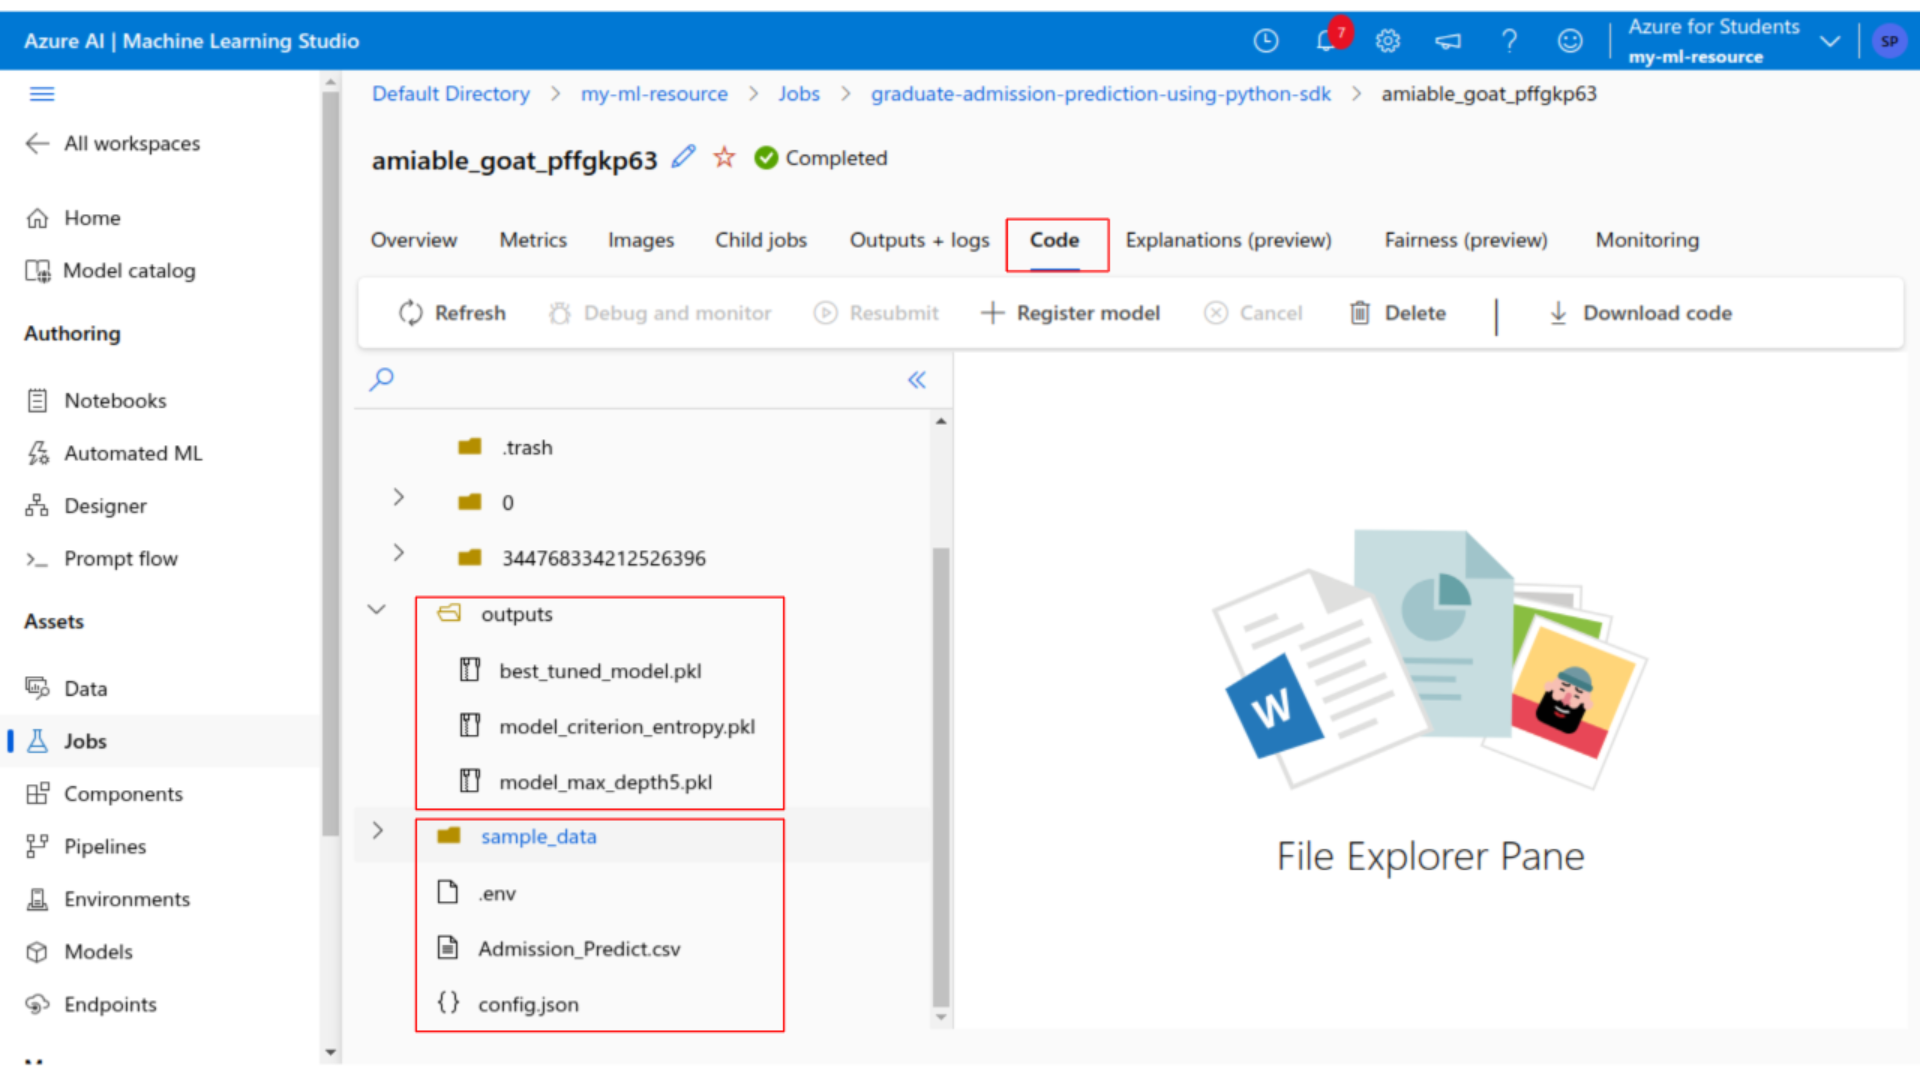

In [ ]:
Image('op3.png')

## To view the output files, go to the 'Output + logs' tab.

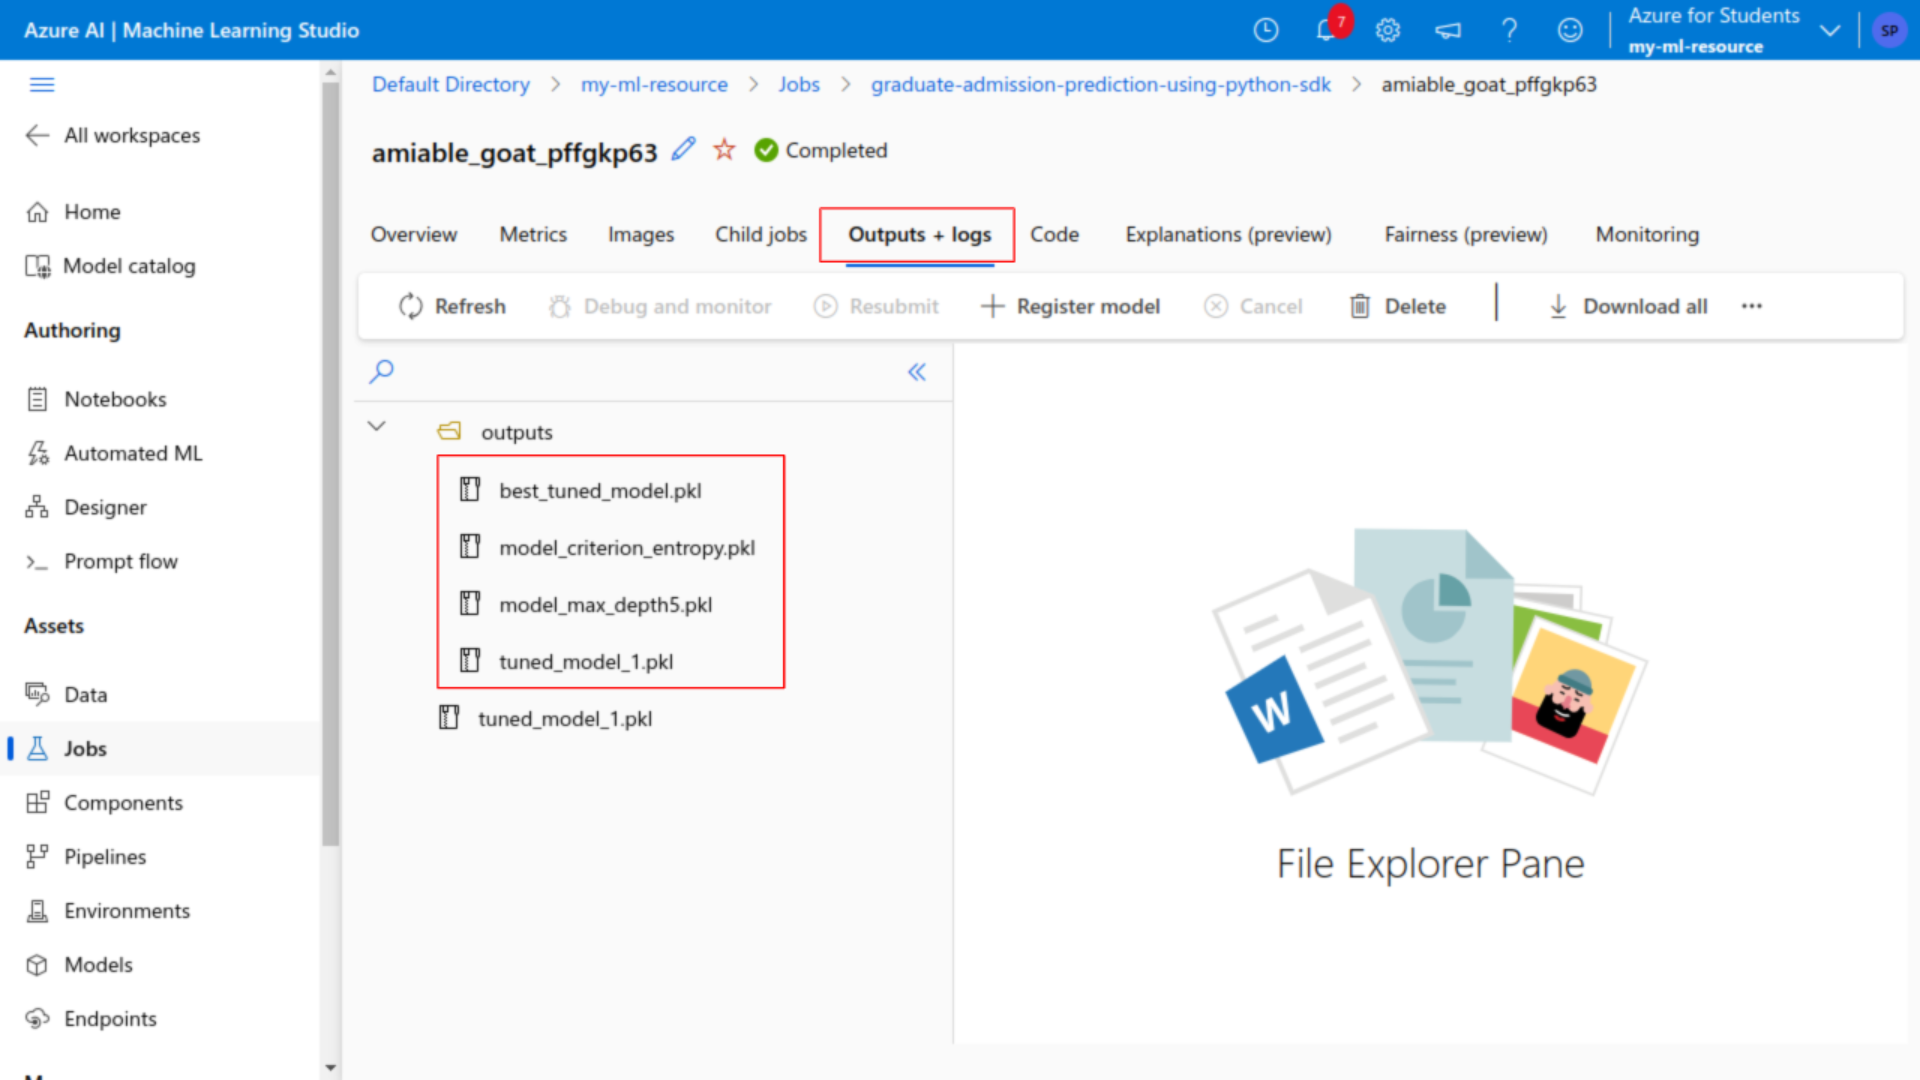

In [ ]:
Image('op5.png')

## To view the model metrics, go to the 'Metrics' tab.

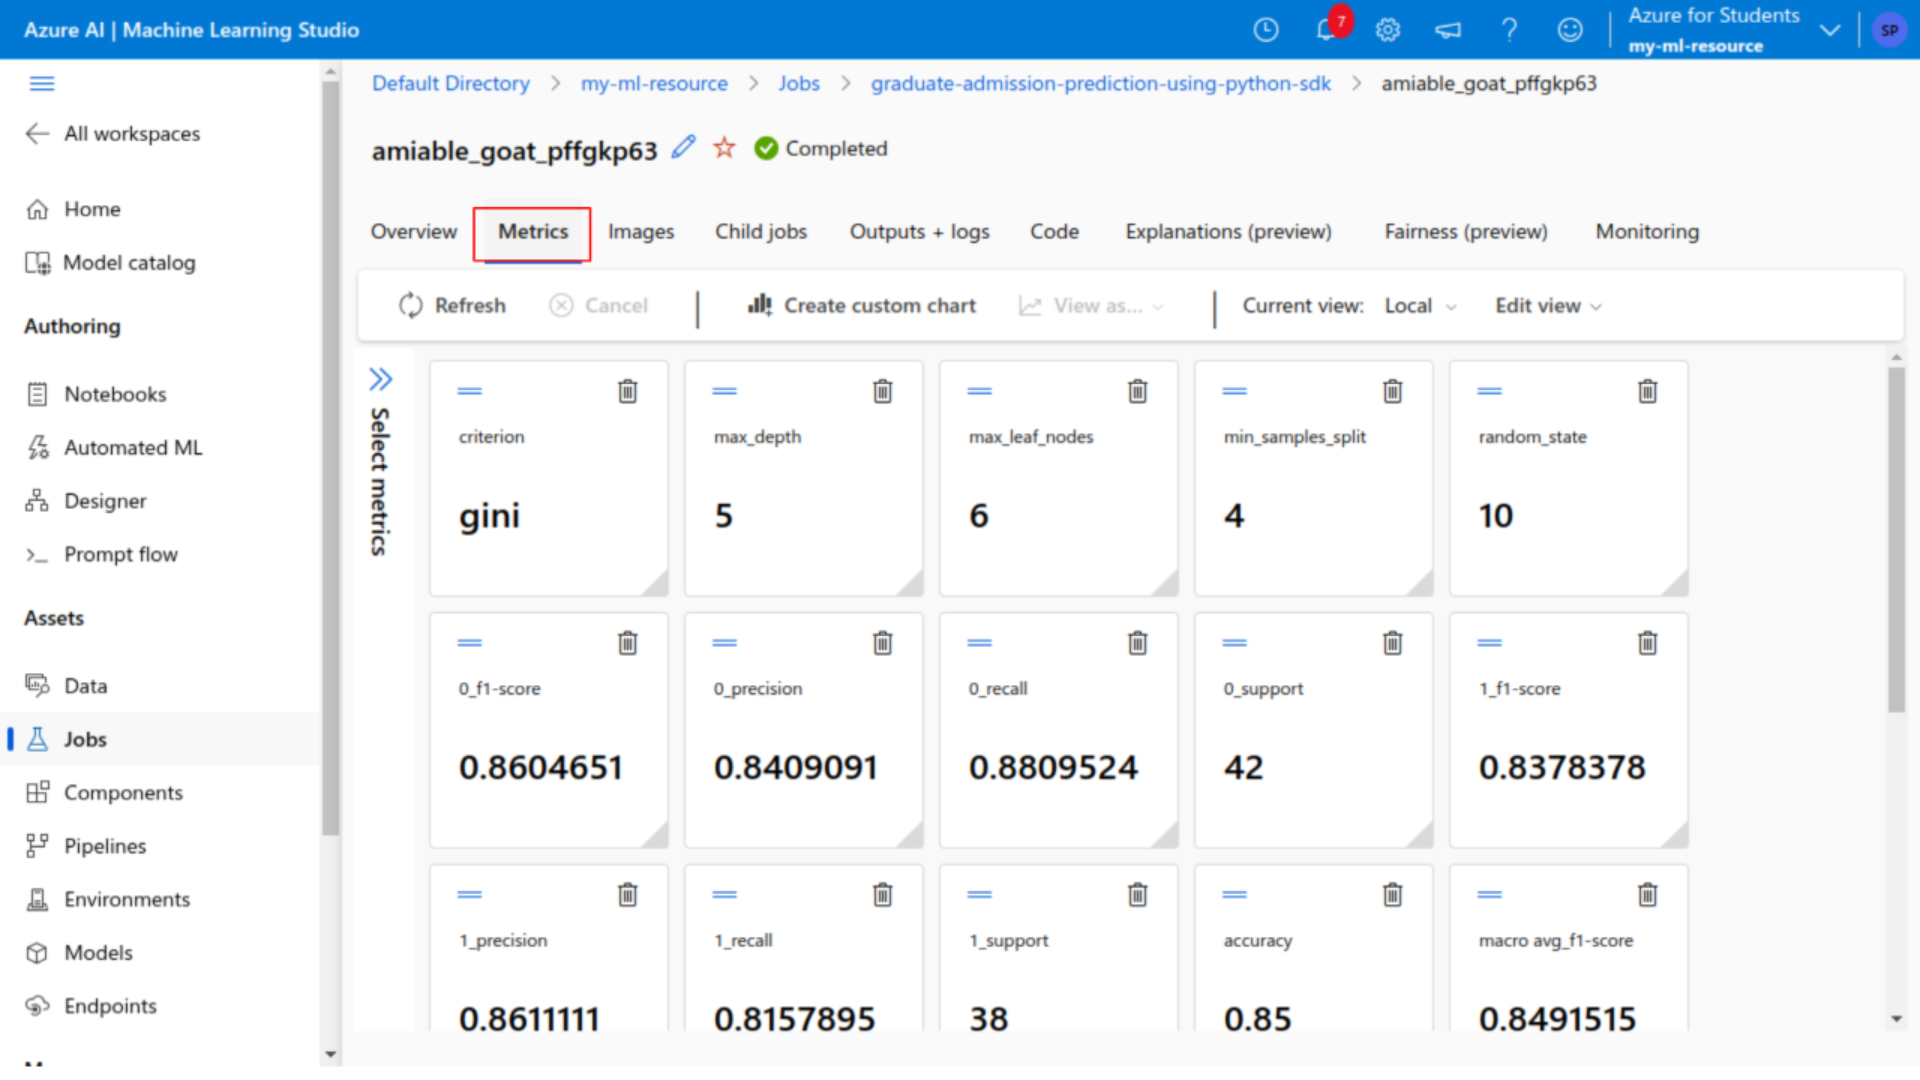

In [ ]:
Image('op4.png')

## View the decision tree

In [ ]:
# save the column names in 'labels'
labels = X_train.columns

# export a decision tree in DOT format
# pass the 'decision_tree' to export it to Graphviz
# pass the column names to 'feature_names'
# pass the required class labels to 'class_names'
dot_data = tree.export_graphviz(decision_tree, feature_names = labels, class_names = ["0","1"])

# plot the decision tree using DOT format in 'dot_data'
graph = pydotplus.graph_from_dot_data(dot_data)

# display the decision tree
Image(graph.create_png())

# double-click on the image below to get an expanded view

Inference: A full decision tree is made, with splitting done on all features in a successive fashion. For example, we start with CGPA at the root node, and then classify based on GRE Score.

The model metrics indicate that theaccuracy is 0.79, which can be improved by fine-tuning the hyperparameters.

## Create a new model by tuning the hyperparameters

In [ ]:
# Model 2:

# pass the criteria 'gini' to the parameter, 'criterion'
# max_depth: that assigns maximum depth of the tree
# min_samples_split: assigns minimum number of samples to split an internal node
# max_leaf_nodes': assigns maximum number of leaf nodes in the tree
# pass the 'random_state' to obtain the same samples for each time you run the code

mlflow.start_run()
run = experiment.start_logging()

dt_model = DecisionTreeClassifier(criterion = 'gini',
                                  max_depth = 5,
                                  min_samples_split = 4,
                                  max_leaf_nodes = 6,
                                  random_state = 10)
run.log("criterion", 'gini')
run.log("max_depth", 5)
run.log('min_samples_split', 4)
run.log('max_leaf_nodes', 6)
run.log('random_state', 10)


# fit the model using fit() on train data
decision_tree = dt_model.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

# viewing the classification report:
print(classification_report(y_test, y_pred))

# Logging all metrics in classification_report
cr = classification_report(y_test, y_pred, output_dict=True)
run.log("accuracy", cr.pop("accuracy"))
for class_or_avg, metrics_dict in cr.items():
      for metric, value in metrics_dict.items():
          run.log(class_or_avg + '_' + metric,value)

model_name = "tuned_model_1" + ".pkl"
filename = "outputs/" + model_name

joblib.dump(value=decision_tree, filename=filename)
run.upload_file(name=model_name, path_or_stream=filename)
run.complete()

mlflow.end_run()

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        42
           1       0.86      0.82      0.84        38

    accuracy                           0.85        80
   macro avg       0.85      0.85      0.85        80
weighted avg       0.85      0.85      0.85        80



## Visualize the tree

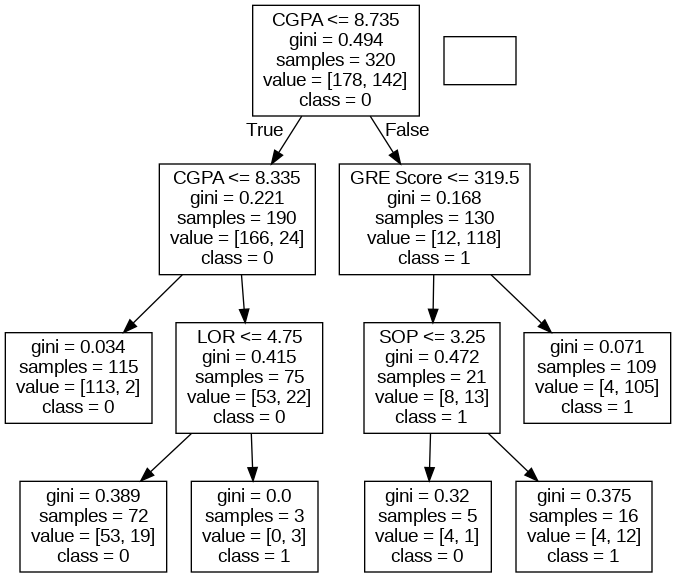

In [ ]:
# save the column names in 'labels'
labels = X_train.columns

# export a decision tree in DOT format
# pass the 'decision_tree' to export it to Graphviz
# pass the column names to 'feature_names'
# pass the required class labels to 'class_names'
dot_data = tree.export_graphviz(dt_model, feature_names = labels, class_names = ["0","1"])

# plot the decision tree using DOT format in 'dot_data'
graph = pydotplus.graph_from_dot_data(dot_data)

# display the decision tree
Image(graph.create_png())

# double-click on the image below to get an expanded view

Inference: Here, we have specified some parameters at random to try and improve our model. In the resulting tree, we can see that far fewer features have been selected, namely, CGPA, GRE score, LOR and SOP.

Thus, out of the six feature variables, we have excluded TOEFL and University Rating in creating this decision tree. Now, we can see that the accuracy has improved to 0.85.

However, we don't know if this set of hyperparameters is the best, or if we can imrpove our model even further. So, we need to implement one more step, to select the best set of hyperparameters possible.

## Find the best hyperparameters using Grid Search:

In [ ]:
# Model 3: Hyperparameter tuning using Grid Search:

# create a dictionary with hyperparameters and its values
# pass the criteria 'entropy' and 'gini' to the parameter, 'criterion'
# pass the range of values to 'max_depth' that assigns maximum depth of the tree
# 'max_features' assigns maximum number of features to consider for the best split. We pass the string 'sqrt' and 'log2'
# 'sqrt' considers maximum number of features equal to the square root of total features
# 'log2' considers maximum number of features equal to the log of total features with base 2
# pass the range of values to 'min_samples_split' that assigns minimum number of samples to split an internal node
# pass the range of values to 'min_samples_leaf' that assigns minimum number of samples required at the terminal/leaf node
# pass the range of values to 'max_leaf_nodes' that assigns maximum number of leaf nodes in the tree

mlflow.start_run()

run = experiment.start_logging()
tuned_parameters = [{'criterion': ['entropy', 'gini'],
                     'max_depth': range(2, 10),
                     'max_features': ["sqrt", "log2"],
                     'min_samples_split': range(2,10),
                     'min_samples_leaf': range(1,10),
                     'max_leaf_nodes': range(1, 10)}]


# instantiate the 'DecisionTreeClassifier'
# pass the 'random_state' to obtain the same samples for each time you run the code
decision_tree_classification = DecisionTreeClassifier(random_state = 10)

# use GridSearchCV() to find the optimal value of the hyperparameters
# estimator: pass the decision tree classifier model
# param_grid: pass the list 'tuned_parameters'
# cv: number of folds in k-fold i.e. here cv = 5
tree_grid = GridSearchCV(estimator = decision_tree_classification,
                         param_grid = tuned_parameters,
                         cv = 5)

# fit the model on X_train and y_train using fit()
tree_grid_model = tree_grid.fit(X_train, y_train)

# get the best parameters
print('Best parameters for decision tree classifier: ', tree_grid_model.best_params_, '\n')

2024/02/16 15:56:43 INFO mlflow.sklearn.utils: Logging the 5 best runs, 20731 runs will be omitted.


Best parameters for decision tree classifier:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'max_leaf_nodes': 3, 'min_samples_leaf': 1, 'min_samples_split': 2} 



In [ ]:
# instantiate the 'DecisionTreeClassifier'
# 'best_params_' returns the dictionary containing best parameter values and parameter name
# 'get()' returns the value of specified parameter
# pass the 'random_state' to obtain the same samples for each time you run the code
mlflow.start_run()
dt_model = DecisionTreeClassifier(criterion = tree_grid_model.best_params_.get('criterion'),
                                  max_depth = tree_grid_model.best_params_.get('max_depth'),
                                  max_features = tree_grid_model.best_params_.get('max_features'),
                                  max_leaf_nodes = tree_grid_model.best_params_.get('max_leaf_nodes'),
                                  min_samples_leaf = tree_grid_model.best_params_.get('min_samples_leaf'),
                                  min_samples_split = tree_grid_model.best_params_.get('min_samples_split'),
                                  random_state = 10)

run.log("criterion", tree_grid_model.best_params_.get('criterion'))
run.log("max_depth", tree_grid_model.best_params_.get('max_depth'))
run.log('max_features', tree_grid_model.best_params_.get('max_features'))
run.log('max_leaf_nodes', tree_grid_model.best_params_.get('max_leaf_nodes'))
run.log('min_samples_leaf',tree_grid_model.best_params_.get('min_samples_leaf'))
run.log('min_samples_split', tree_grid_model.best_params_.get('min_samples_split'))
run.log('random_state', 10)


# use fit() to fit the model on the train set
dt_model = dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

# viewing the classification report
print(classification_report(y_test, y_pred))

# Logging all metrics in classification_report
cr = classification_report(y_test, y_pred, output_dict=True)
run.log("accuracy", cr.pop("accuracy"))
for class_or_avg, metrics_dict in cr.items():
      for metric, value in metrics_dict.items():
          run.log(class_or_avg + '_' + metric,value)

model_name = "best_tuned_model" + ".pkl"
filename = "outputs/" + model_name

joblib.dump(value=decision_tree, filename=filename)
run.upload_file(name=model_name, path_or_stream=filename)
run.complete()

mlflow.end_run()

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        42
           1       0.84      0.84      0.84        38

    accuracy                           0.85        80
   macro avg       0.85      0.85      0.85        80
weighted avg       0.85      0.85      0.85        80



## View the decision tree

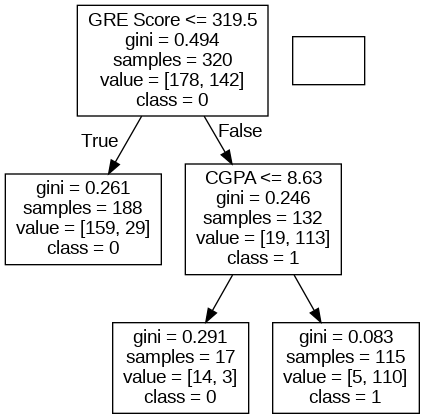

In [ ]:
# save the column names in 'labels'
labels = X_train.columns

# export a decision tree in DOT format
# pass the 'decision_tree' to export it to Graphviz
# pass the column names to 'feature_names'
# pass the required class labels to 'class_names'
dot_data = tree.export_graphviz(dt_model, feature_names = labels, class_names = ["0","1"])

# plot the decision tree using DOT format in 'dot_data'
graph = pydotplus.graph_from_dot_data(dot_data)

# display the decision tree
Image(graph.create_png())

# double-click on the image below to get an expanded view

Inference: Compared to the last model, the accuracy of this decision tree is still the same. However, we can see that the tree has been pruned even more than the previous model. Now, we have isolated the two most significant features, namely, GRE Score and CGPA.

Thus, we can conclude that to predict whether the student will gain admission in the Master's program, the two most signficant variables are GRE Score and CGPA. This model is also 85% accurate.

# Closing the Project

## Delete the resources
You can retain an **empty** resource group as it will not charge credits. However, all the resources that have been created, have to be diligently deleted to avoid incurring extra costs.

For simpler closing operations, delete the entire resource group. To keep the same resource group, delete all the resources contained within it.

Refresh the page, until all the resources have been deleted.

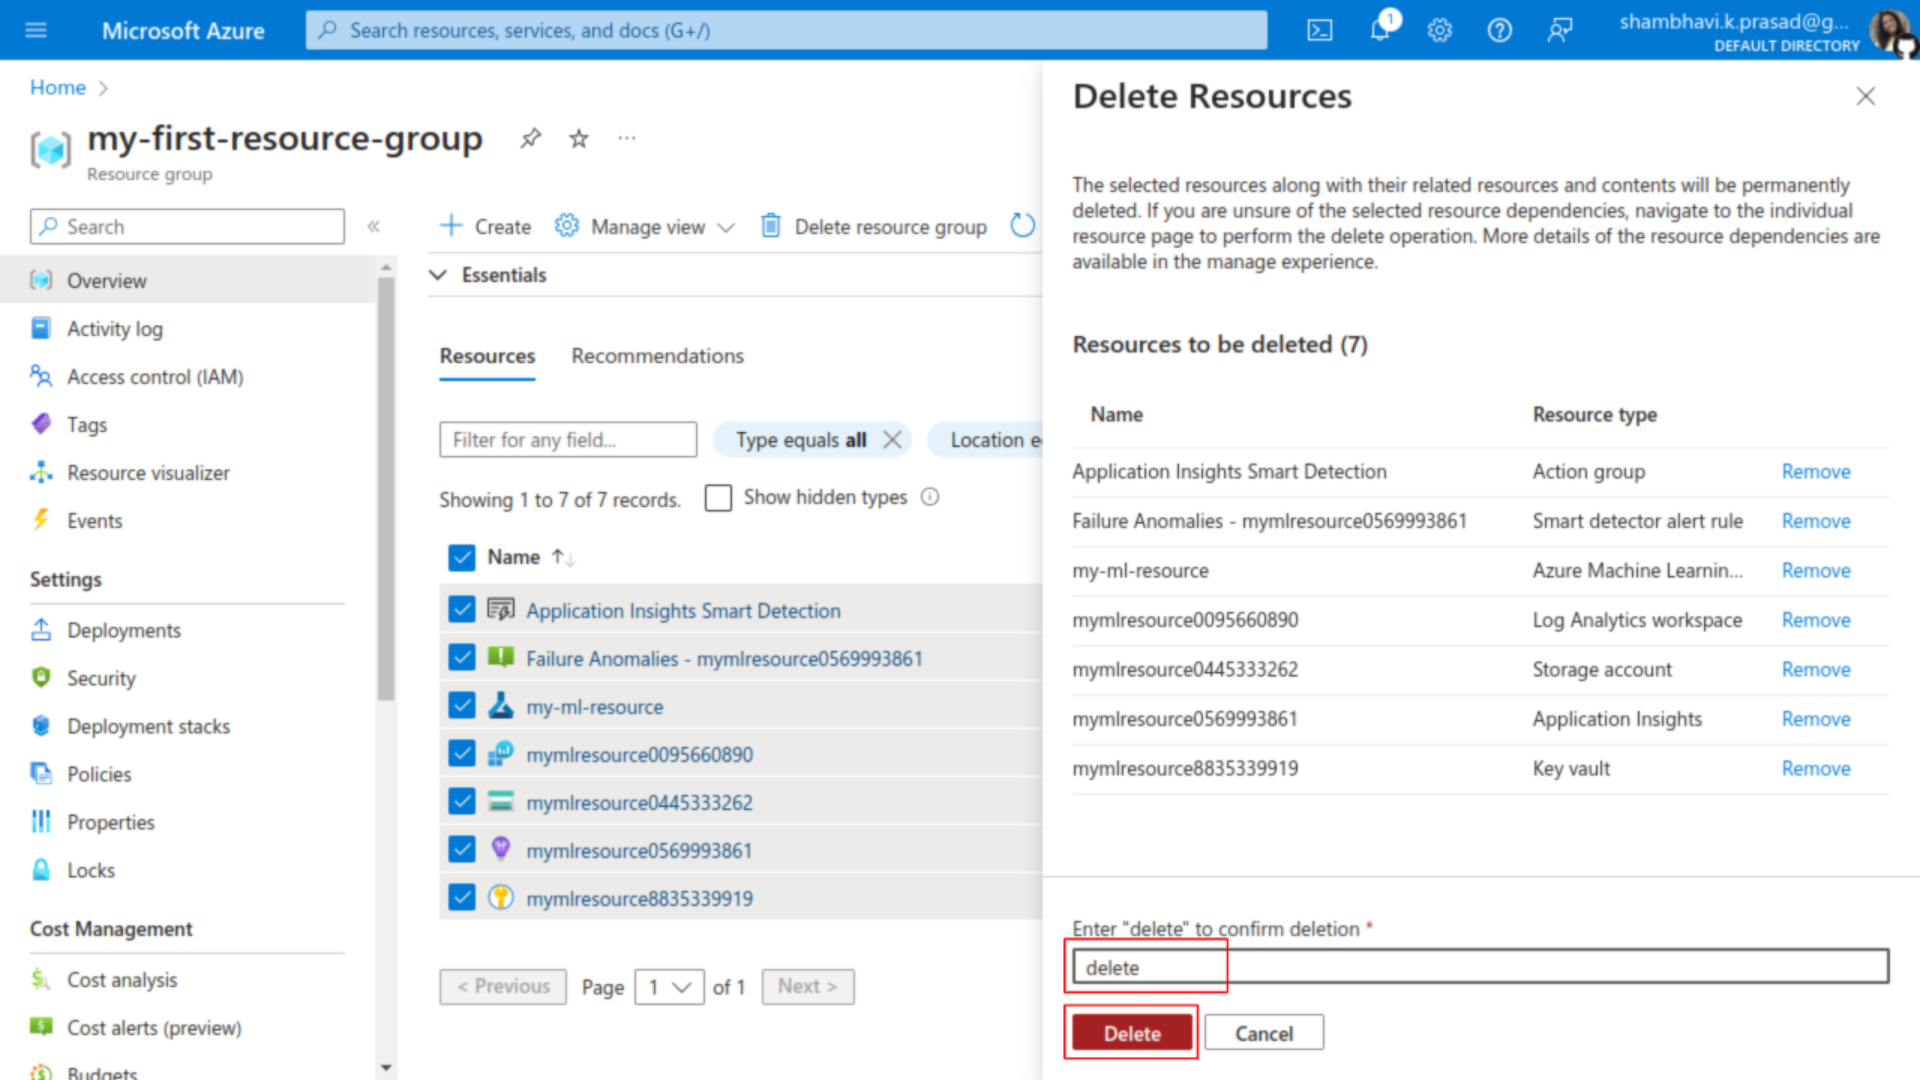

In [ ]:
Image('op6.png')